24


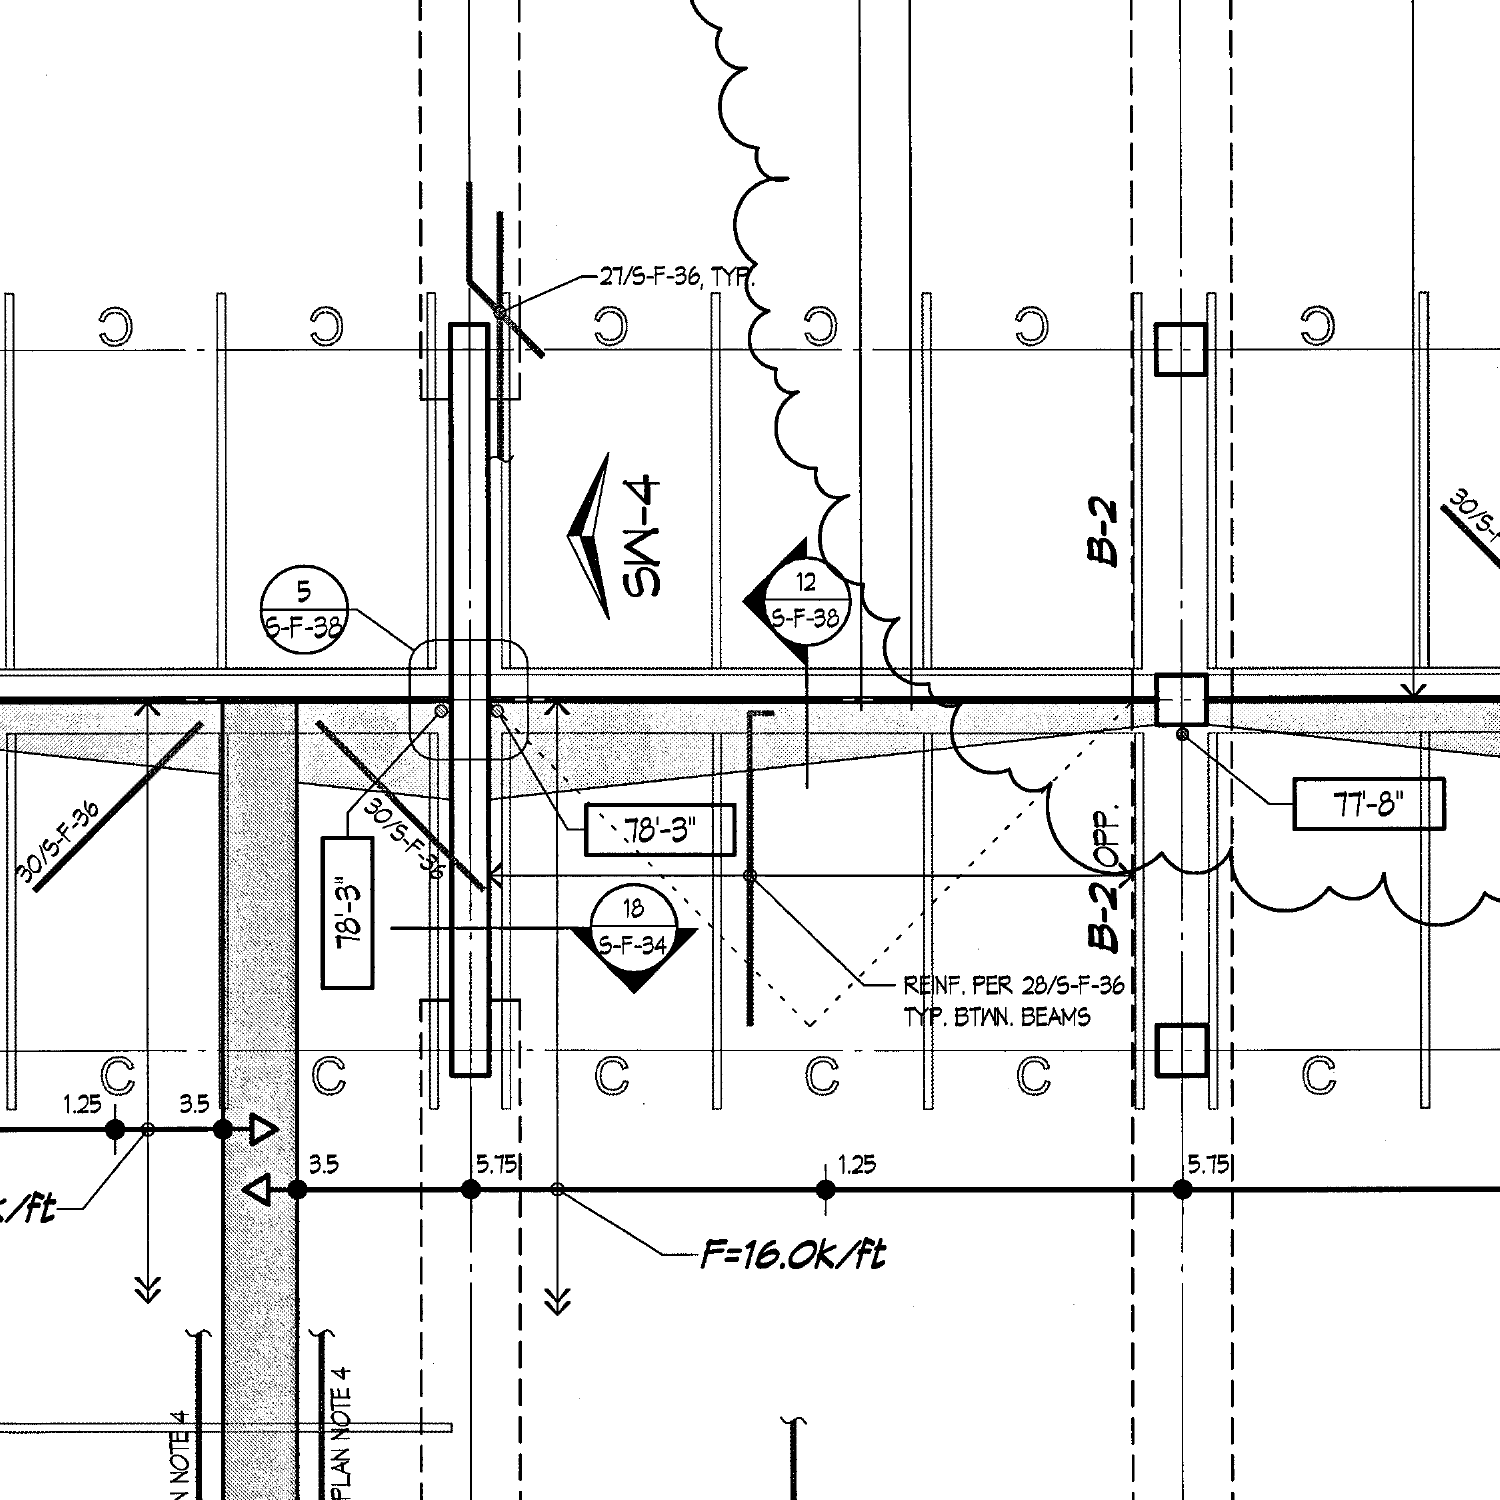

In [1]:
from ocr.line_detector import tile_image
import numpy as np
from PIL import Image
import cv2

img = cv2.imread("/home/sadid/PycharmProjects/sgs-drawing-analysis/data/miliennium_garage/original4.png")
height, width = img.shape[:2]
tiles = tile_image(img)
# tile = img[1000:2000, 2500:4000].copy()
tile = tiles[14][0].copy()
print(len(tiles))

Image.fromarray(tile)

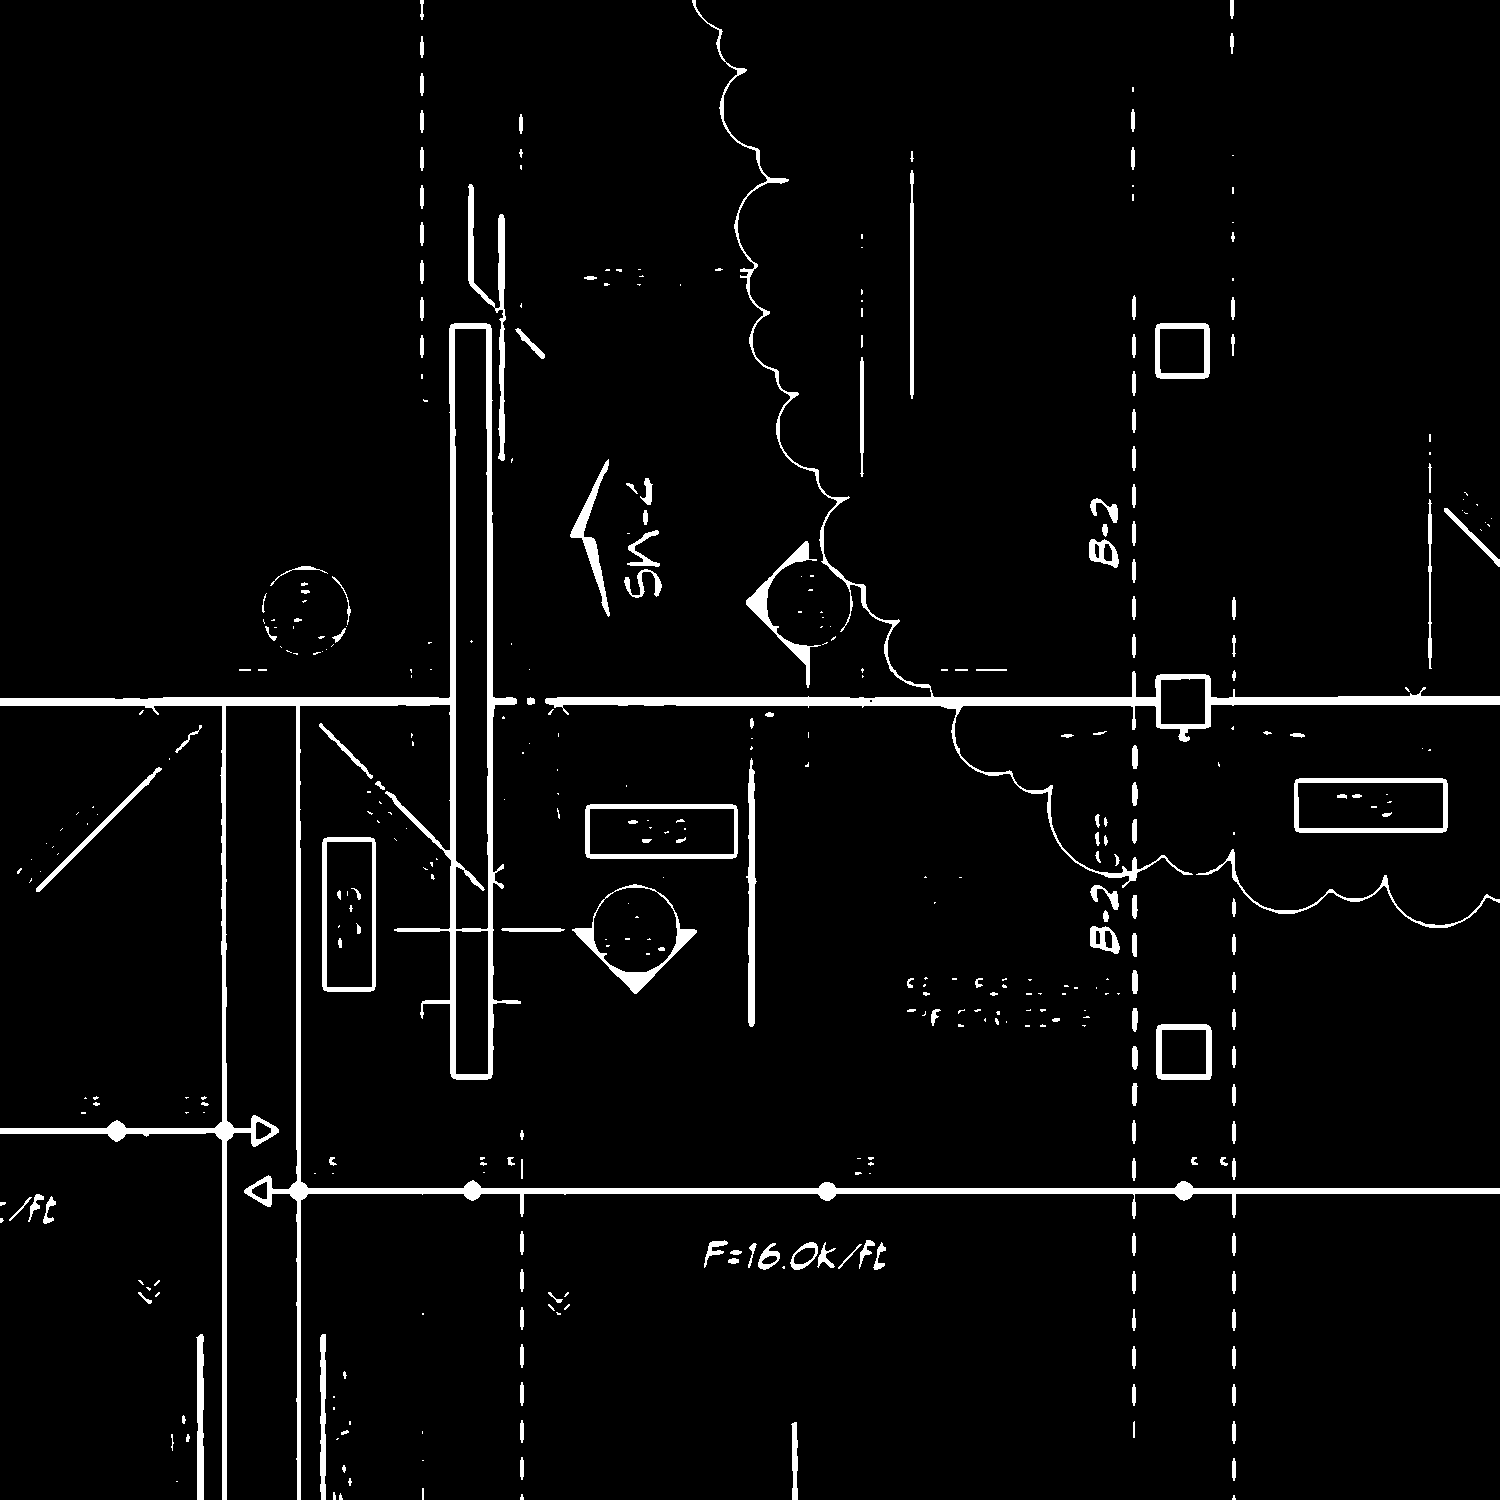

In [2]:
gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((2, 2), np.uint8)
erode = cv2.erode(thresh, kernel)

blur = cv2.GaussianBlur(erode, (7, 7), 0)
ret, thresh = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY_INV)
erode = cv2.erode(thresh, kernel)

blur = cv2.GaussianBlur(erode, (5, 5), 0)
ret, thresh = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY_INV)
erode = cv2.erode(thresh, kernel)

Image.fromarray(erode)

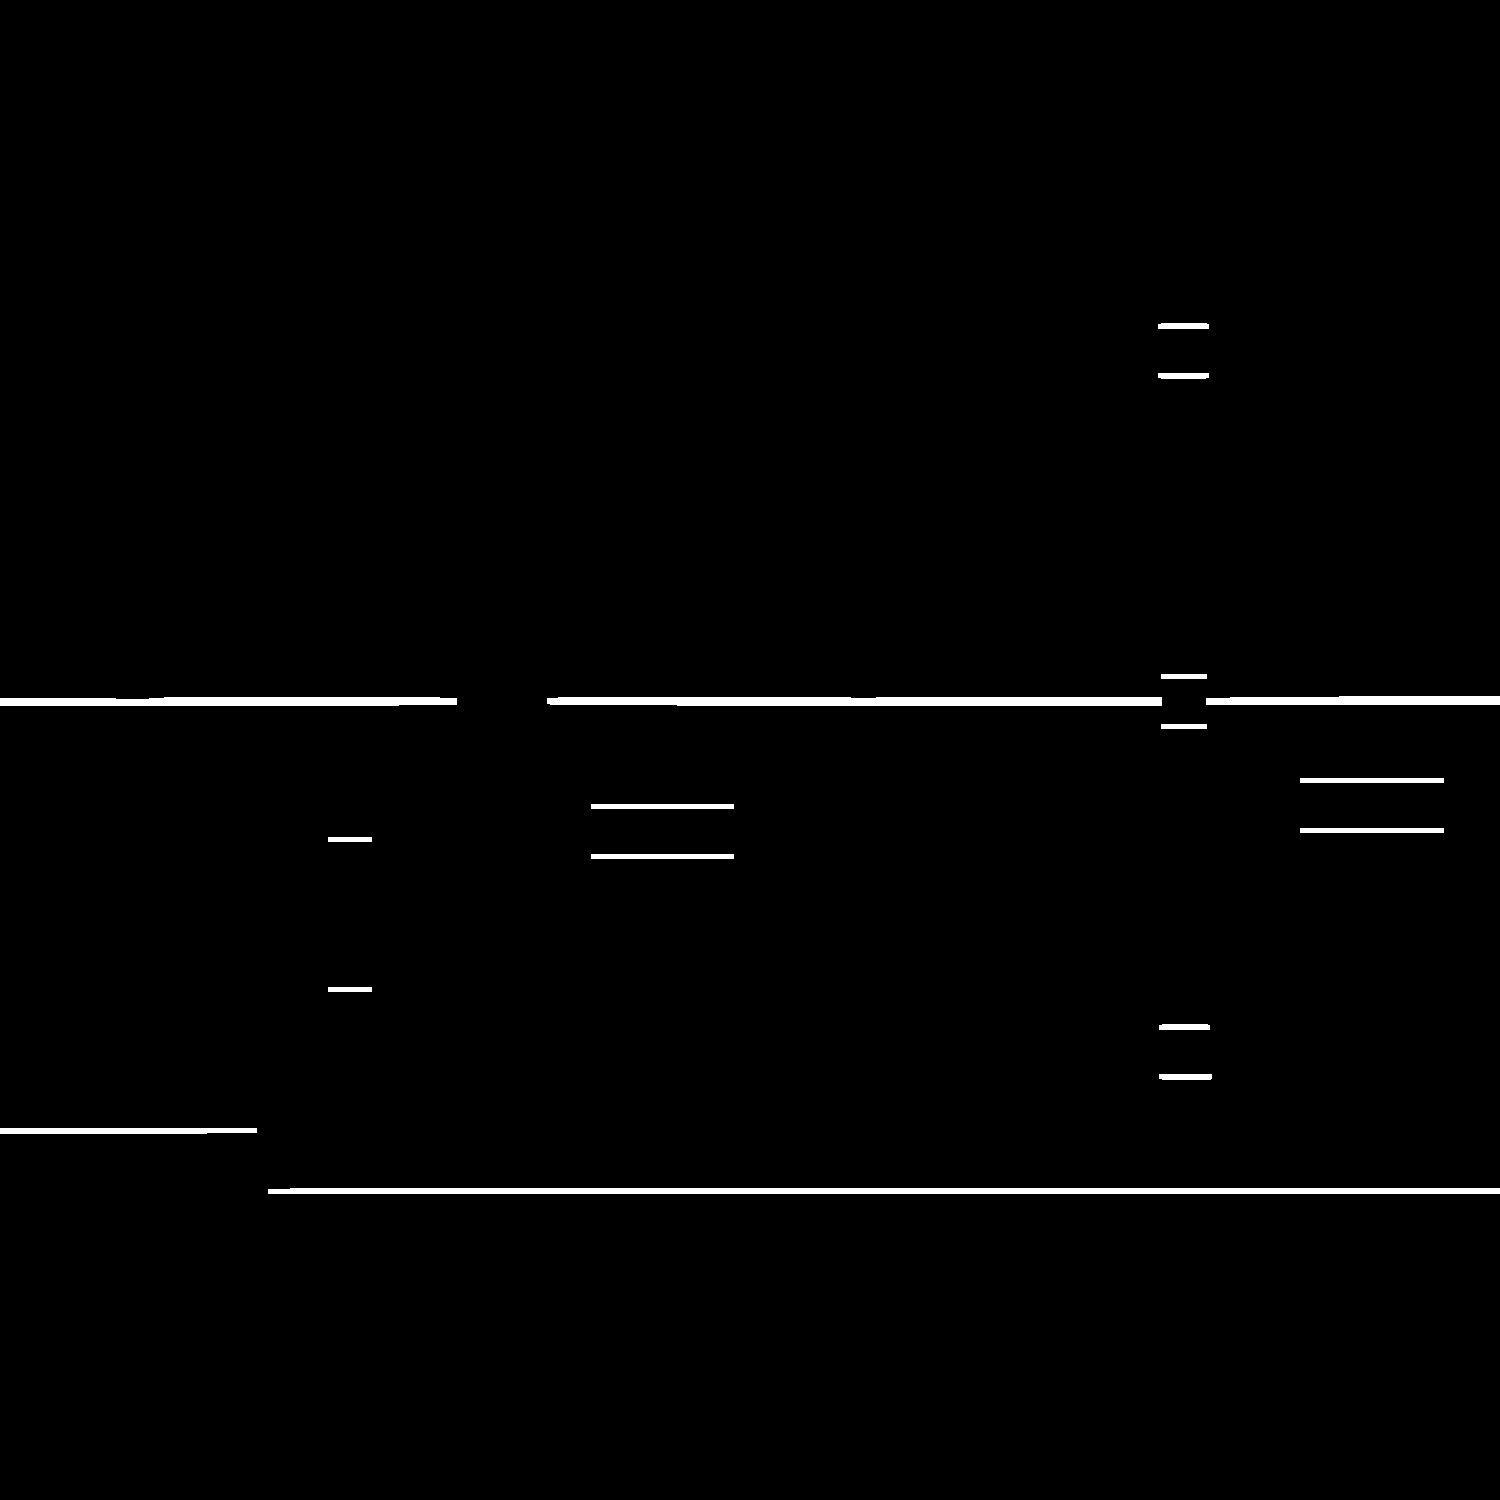

In [3]:
kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (40, 5)   # wide and flat
)

horizontal = cv2.morphologyEx(erode, cv2.MORPH_OPEN, kernel)
horizontal = cv2.morphologyEx(
    horizontal,
    cv2.MORPH_CLOSE,
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
)
Image.fromarray(horizontal)

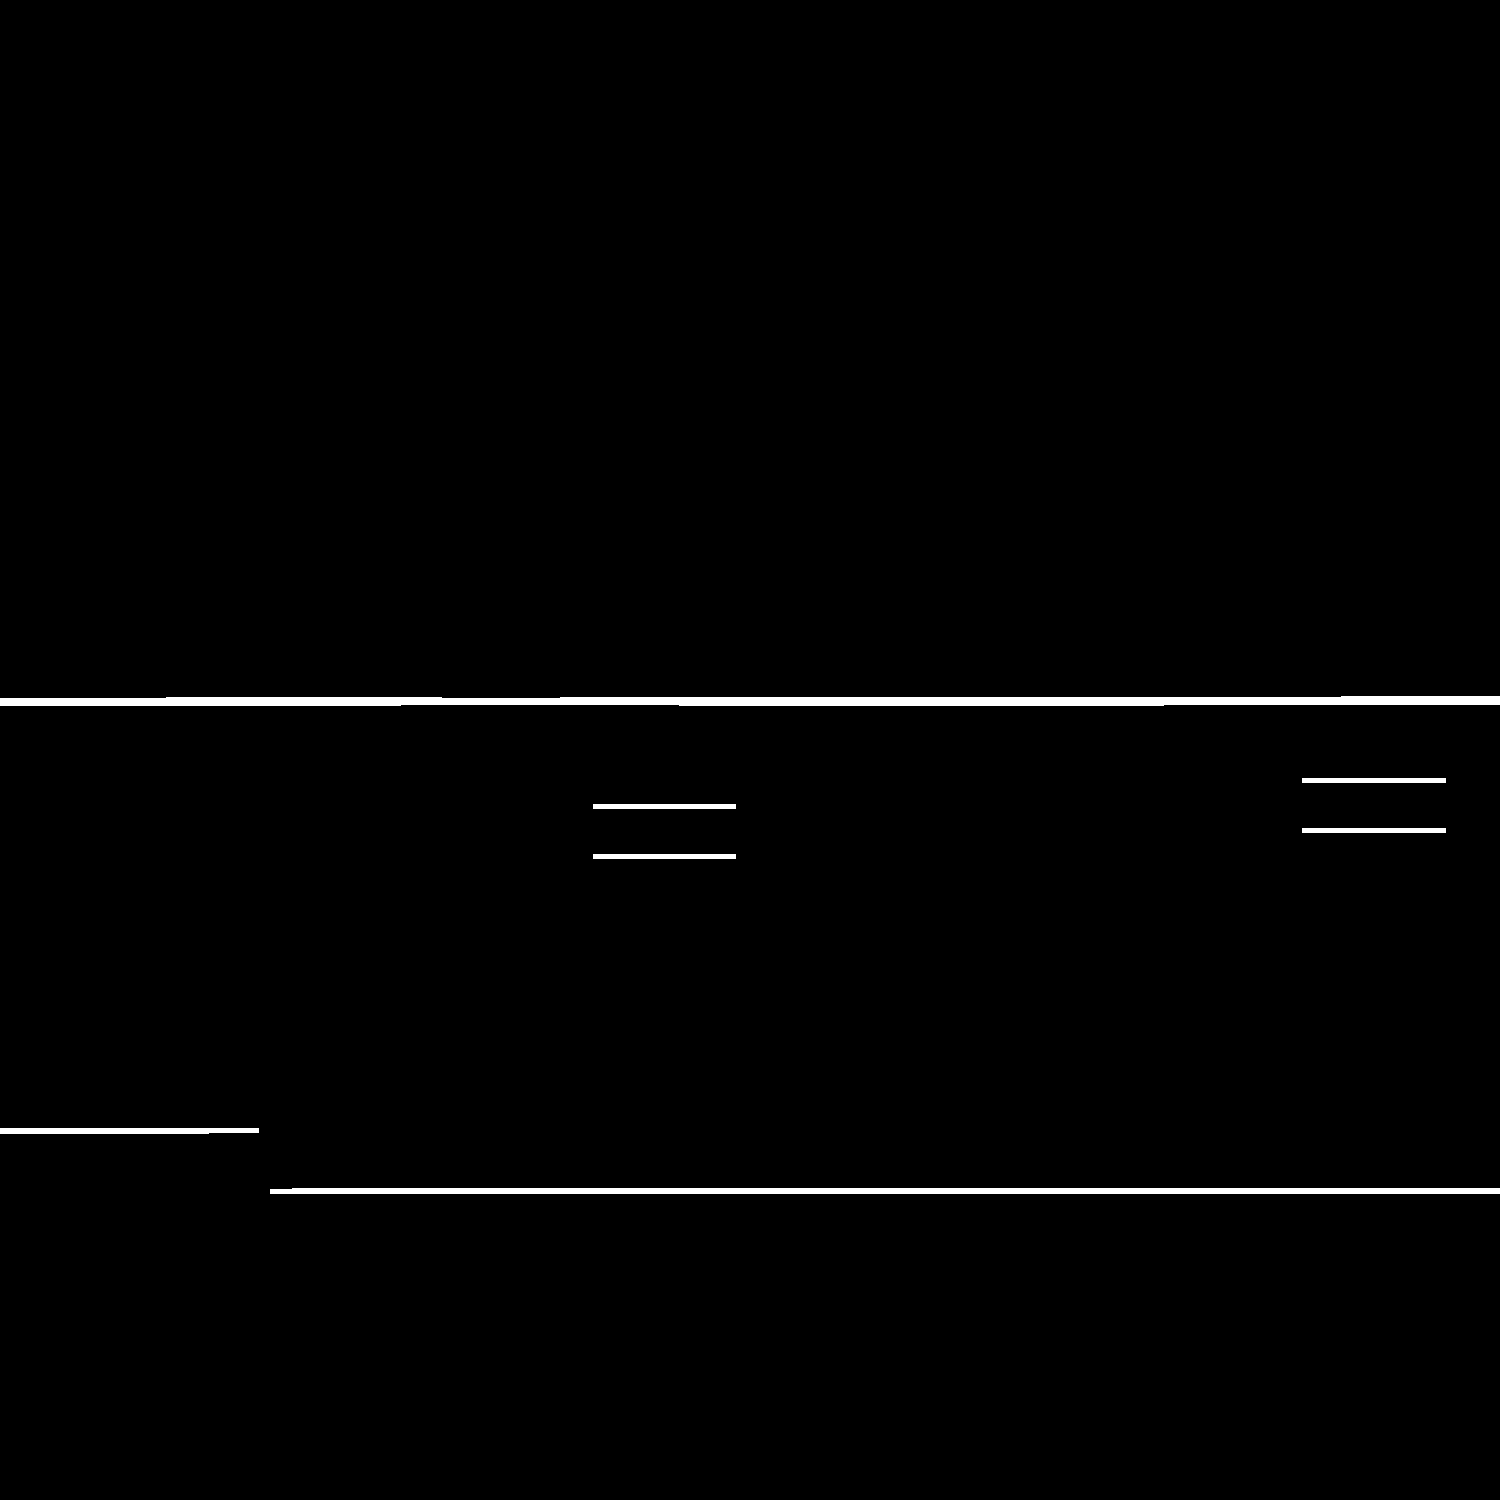

In [4]:
bridge_kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (100, 1)   # width > expected vertical-line thickness
)

bw_bridged = cv2.morphologyEx(
    horizontal,
    cv2.MORPH_CLOSE,
    bridge_kernel
)

extract_kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (60, 1)
)

horizontal = cv2.morphologyEx(
    bw_bridged,
    cv2.MORPH_OPEN,
    extract_kernel
)

Image.fromarray(horizontal)

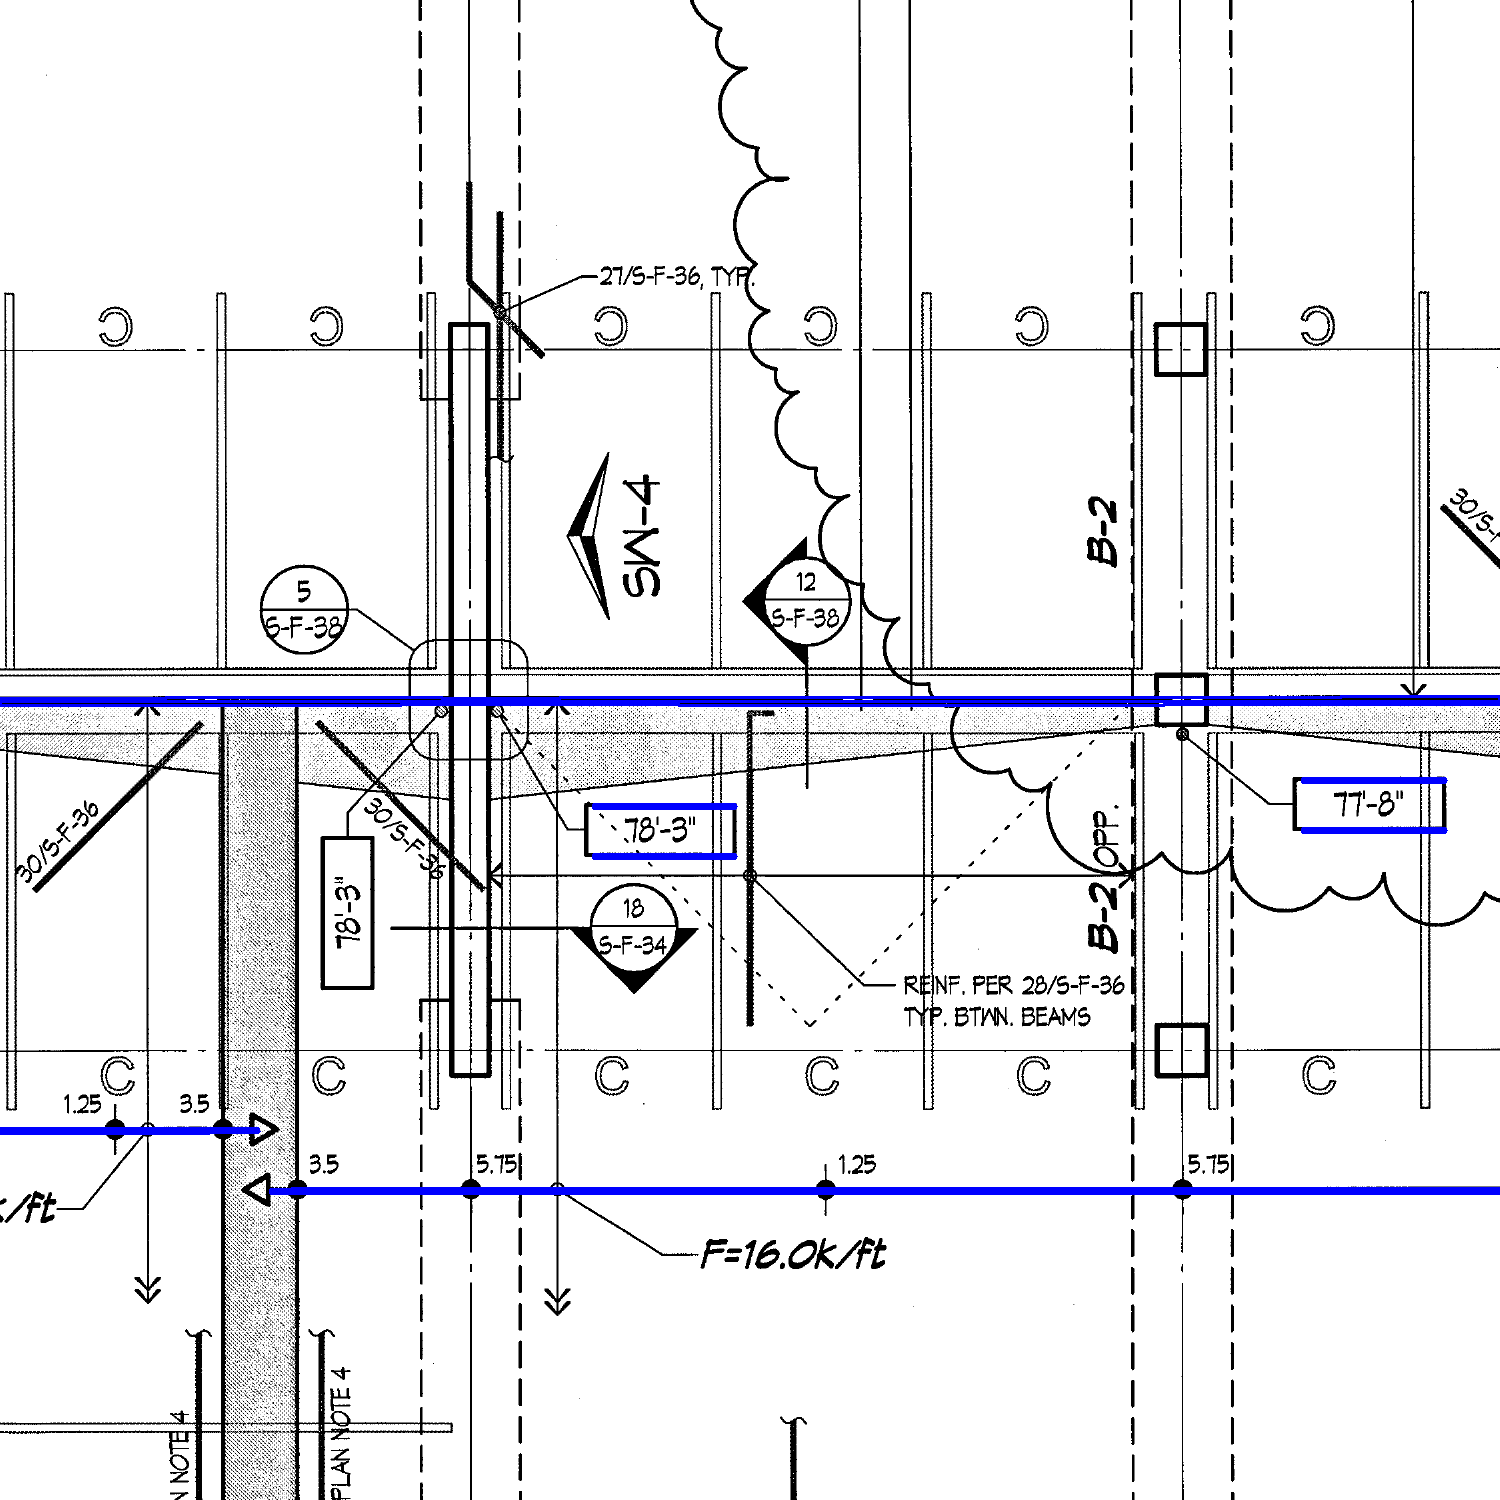

In [5]:
contours, _ = cv2.findContours(horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_copy = tile.copy()

final_lines = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.drawContours(image_copy, [cnt], 0, (0, 0, 255), 2)

    if w > 100 and h < 15:
        final_lines.append((x, y + h//2, x + w, y + h//2))

results = []
if final_lines is not None:
    for l in final_lines:
        x1, y1, x2, y2 = l

        # keep horizontal or vertical
        if abs(x1 - x2) < 10 or abs(y1 - y2) < 10:
            results.append((x1, y1, x2, y2))
            cv2.line(image_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

Image.fromarray(image_copy)